In [61]:
import random
import matplotlib
import pandas as pd
import time
import graphviz
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import tree, DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline

In [62]:
#custom tokenizer for URLs. 
#first split - "/"
#second split - "-"
#third split - "."
#remove ".com" (also "http://", but we dont have "http://" in our dataset)
def getTokens(input):
    tokensBySlash = str(input.encode('utf-8')).split('/')
    allTokens = []
    for i in tokensBySlash:
        tokens = str(i).split('-')
        tokensByDot = []
        for j in range(0,len(tokens)):
            tempTokens = str(tokens[j]).split('.')
            tokensByDot = tokensByDot + tempTokens
        allTokens = allTokens + tokens + tokensByDot
    allTokens = list(set(allTokens))
    if 'com' in allTokens:
        allTokens.remove('com')
    return allTokens

#function to remove "http://" from URL
def trim(url):
    return re.match(r'(?:\w*://)?(?:.*\.)?([a-zA-Z-1-9]*\.[a-zA-Z]{1,}).*', url).groups()[0]


In [63]:
df = pd.read_csv(r'C:\Users\Kephas\Desktop\Demo\dataset.csv',',',error_bad_lines=False)
df=df.sample(frac=1)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,URL,Lable
0,http://thaidomainhosting.com/billing/includes/...,1
1,http://www.skcmanagement.com/,0
2,http://computype.bizland.com/,0
3,http://islingtonbloordentist.com/sent/meant/ya...,1
4,http://www.airberlin.com/site/redirect.php?url...,1


In [64]:
#displaying the number of rows in a dataset
len(df) 

7030

In [65]:
#data['url'].values
x = df.iloc[:,0:1].values
y = df.iloc[:,1].values

In [66]:
#convert it into numpy array and shuffle the dataset
df = np.array(df)
random.shuffle(df)

In [67]:
#convert text data into numerical data for machine learning models
y = [d[1] for d in df]
corpus = [d[0] for d in df]
vectorizer = TfidfVectorizer(tokenizer=getTokens)
X = vectorizer.fit_transform(corpus)

In [68]:
#split the data set inot train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [69]:
CART = tree.DecisionTreeClassifier(criterion='entropy',max_depth=2, random_state=0)
CART.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [70]:
y_pred_class = CART.predict(X_test)
print("Accuracy: ",CART.score(X_test, y_test))

Accuracy:  0.8620199146514936


In [71]:
predicted =CART.predict(X_test)
cm = confusion_matrix(y_test, predicted)
print(cm)

print("False positive rate : %.2f %%" % ((cm[0][1] / float(sum(cm[0])))*100))
print('False negative rate : %.2f %%' % ( (cm[1][0] / float(sum(cm[1]))*100)))

[[568 126]
 [ 68 644]]
False positive rate : 18.16 %
False negative rate : 9.55 %


In [72]:
report = classification_report(y_test, predicted)
print(report)

             precision    recall  f1-score   support

          0       0.89      0.82      0.85       694
          1       0.84      0.90      0.87       712

avg / total       0.86      0.86      0.86      1406



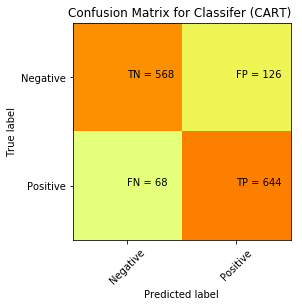

In [73]:
# Plot with Labels
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
plt.title('Confusion Matrix for Classifer (CART) ')

#sns.heatmap(matrix,annot=True,fmt="d")
# Set x-axis label
classNames = ['Negative','Positive']
plt.xlabel('Predicted label')
# Set y-axis label
plt.ylabel('True label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [74]:
# predict probabilities
probs = CART.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)

AUC: 0.888


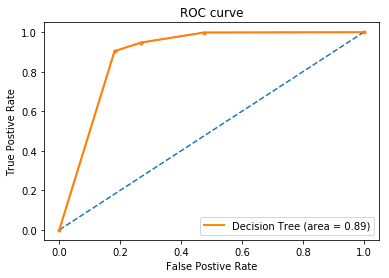

In [75]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
#print(fpr, tpr, thresholds)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='Decision Tree (area = %0.2f)' % auc)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Postive Rate')
plt.ylabel('True Postive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
# show the plot
plt.show()

f1=0.869
ap=0.826


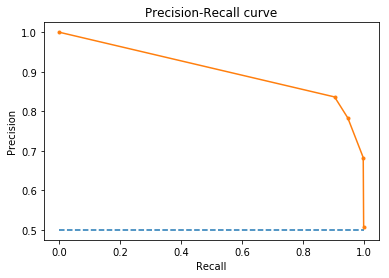

In [76]:
# predict class values
predicted = CART.predict(X_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
# calculate F1 score
f1 = f1_score(y_test, predicted)
# calculate precision-recall AUC
#auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test, probs)
print('f1=%.3f' % (f1))
#print('auc=%.3f' % (auc))
print('ap=%.3f' % (ap))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
# show the plot
plt.show()

In [77]:
#Predicting With Our Model
X_predict = ["google.com/search=jcharistech",
"google.com/search=faizanahmad", 
"www.radsport-voggel.de/wp-admin/includes/log.exe", 
"ahrenhei.without-transfer.ru/nethost.exe ",
"www.itidea.it/centroesteticosothys/img/_notes/gum.exe"]

X_predict = vectorizer.transform(X_predict)
New_predict = CART.predict(X_predict)


print("New prediction",New_predict)

New prediction [1 1 1 1 1]


In [78]:
X_predict1 = ["www.buyfakebillsonlinee.blogspot.com", 
"www.unitedairlineslogistics.com",
"www.stonehousedelivery.com",
"www.silkroadmeds-onlinepharmacy.com" ]

X_predict1 = vectorizer.transform(X_predict1)
New_predict1 = CART.predict(X_predict1)
print(New_predict1)

[1 1 1 1]


In [79]:
#Testing using legitimate URLs
X_predict_2 =["cleveland.about.com/od/clevelandbrowns/a/browns06.htm",
"cleveland.about.com/od/clevelandbrowns/p/bradyquinn.htm",
"cleveland.about.com/od/neighborhoods/p/shakerheights.htm",
"cleveland.about.com/od/theater/p/karamu.htm",
"cleveland.about.com/od/theater/tp/clevelandtheater.htm",
"cleveland.about.com/od/visitingcleveland/ig/Cleveland-Ohio-Visitors-Guide/Cleveland-Restaurants.htm",
"cleveland.apartments.com/",
"cleveland.backpage.com/Classes/the-ocean-corp-10840-rockley-road-houston-texas-77099-train/5960203"
]

X_predict_2 = vectorizer.transform(X_predict_2)
New_prediction2 = CART.predict(X_predict_2)
print(New_prediction2)

[1 1 1 1 1 1 0 1]
